[[  9.6247833 ]
 [ 90.94517838]
 [150.11069746]
 [  0.27032765]
 [239.85756708]
 [  0.84565921]]


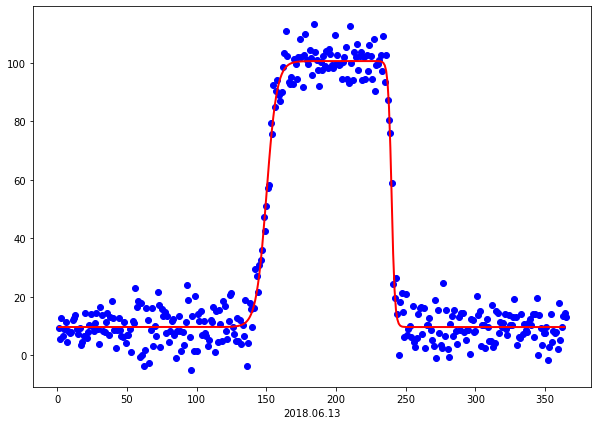

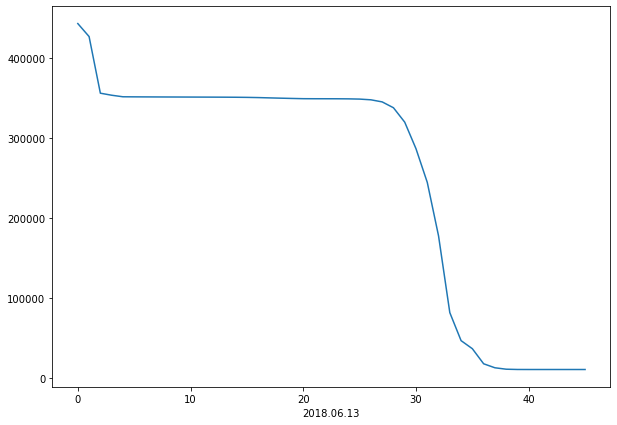

In [2]:
'''
#Implement LM algorithm only using basic python
#Author:Leo Ma
#For csmath2019 assignment4,ZheJiang University
#Date:2019.04.28
'''
import numpy as np
import matplotlib.pyplot as plt 

#input data, whose shape is (num_data,1)
#data_input=np.array([[0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8]]).T
#data_output=np.array([[19.21, 18.15, 15.36, 14.10, 12.89, 9.32, 7.45, 5.24, 3.01]]).T


tao = 10**-3
threshold_stop = 10**-10
threshold_step = 10**-5
threshold_residual = 10**-10
residual_memory = []



#construct a user function
def my_Func(params,input_data):
    a = params[0,0]
    b = params[1,0]
    c = params[2,0]
    d = params[3,0]
    e = params[4,0]
    f = params[5,0]
    # return a*np.exp(b*input_data)
    # return a*np.sin(b*input_data[:,0])+c*np.cos(d*input_data[:,1])
    return a+b/(1+np.exp(-1*d*(input_data-c)))-b/(1+np.exp(-1*f*(input_data-e)))


    
#generating the input_data and output_data,whose shape both is (num_data,1)
def generate_data(params,num_data):
    x = np.array(np.linspace(1,365,num_data)).reshape(num_data,1)       # 产生包含噪声的数据
    mid,sigma = 0,5
    y = my_Func(params,x) + np.random.normal(mid, sigma, num_data).reshape(num_data,1)
    return x,y
    

#calculating the derive of pointed parameter,whose shape is (num_data,1)
def cal_deriv(params,input_data,param_index):
    params1 = params.copy()
    params2 = params.copy()
    params1[param_index,0] += 0.000001
    params2[param_index,0] -= 0.000001
    data_est_output1 = my_Func(params1,input_data)
    data_est_output2 = my_Func(params2,input_data)
    return (data_est_output1 - data_est_output2) / 0.000002

#calculating jacobian matrix,whose shape is (num_data,num_params)
def cal_Jacobian(params,input_data):
    num_params = np.shape(params)[0]
    num_data = np.shape(input_data)[0]
    J = np.zeros((num_data,num_params))
    for i in range(0,num_params):
        J[:,i] = list(cal_deriv(params,input_data,i))
    return J

#calculating residual, whose shape is (num_data,1)
def cal_residual(params,input_data,output_data):
    data_est_output = my_Func(params,input_data)
    residual = output_data - data_est_output
    return residual
    

'''    
#calculating Hessian matrix, whose shape is (num_params,num_params)
def cal_Hessian_LM(Jacobian,u,num_params):
    H = Jacobian.T.dot(Jacobian) + u*np.eye(num_params)
    return H
    
#calculating g, whose shape is (num_params,1)
def cal_g(Jacobian,residual):
    g = Jacobian.T.dot(residual)
    return g

#calculating s,whose shape is (num_params,1)
def cal_step(Hessian_LM,g):
    s = Hessian_LM.I.dot(g)
    return s
     
'''


#get the init u, using equation u=tao*max(Aii)
def get_init_u(A,tao):
    m = np.shape(A)[0]
    Aii = []
    for i in range(0,m):
        Aii.append(A[i,i])
    u = tao*max(Aii)
    return u
    
#LM algorithm
def LM(num_iter,params,input_data,output_data):
    num_params = np.shape(params)[0]#the number of params
    k = 0#set the init iter count is 0
    #calculating the init residual
    residual = cal_residual(params,input_data,output_data)
    #calculating the init Jocobian matrix
    Jacobian = cal_Jacobian(params,input_data)
    
    A = Jacobian.T.dot(Jacobian)#calculating the init A
    g = Jacobian.T.dot(residual)#calculating the init gradient g
    stop = (np.linalg.norm(g, ord=np.inf) <= threshold_stop)#set the init stop
    u = get_init_u(A,tao)#set the init u
    v = 2#set the init v=2
    
    while((not stop) and (k<num_iter)):
        k+=1
        while(1):
            Hessian_LM = A + u*np.eye(num_params)#calculating Hessian matrix in LM
            step = np.linalg.inv(Hessian_LM).dot(g)#calculating the update step
            if(np.linalg.norm(step) <= threshold_step):
                stop = True
            else:
                new_params = params + step#update params using step
                new_residual = cal_residual(new_params,input_data,output_data)#get new residual using new params
                rou = (np.linalg.norm(residual)**2 - np.linalg.norm(new_residual)**2) / (step.T.dot(u*step+g))
                if rou > 0:
                    params = new_params
                    residual = new_residual
                    residual_memory.append(np.linalg.norm(residual)**2)
                    #print (np.linalg.norm(new_residual)**2)
                    Jacobian = cal_Jacobian(params,input_data)#recalculating Jacobian matrix with new params
                    A = Jacobian.T.dot(Jacobian)#recalculating A
                    g = Jacobian.T.dot(residual)#recalculating gradient g
                    stop = (np.linalg.norm(g, ord=np.inf) <= threshold_stop) or (np.linalg.norm(residual)**2 <= threshold_residual)
                    u = u*max(1/3,1-(2*rou-1)**3)
                    v = 2
                else:
                    u = u*v
                    v = 2*v
            if(rou > 0 or stop):
                break;
        
    return params
  


        
        
def main():
    #set the true params for generate_data() function
    params = np.zeros((6,1))
    params[0,0]=10.0
    params[1,0]=90
    params[2,0]=150
    params[3,0]=0.3
    params[4,0]=240
    params[5,0]=0.8

    num_data = 365# set the data number
    data_input,data_output = generate_data(params,num_data)#generate data as requested
    
    # print('data_input',data_input)
    # print('data_output',data_output)

    #set the init params for LM algorithm 
    params[0,0]=0
    params[1,0]=80
    params[2,0]=120
    params[3,0]=0.1
    params[4,0]=200
    params[5,0]=0.1
#     params[0,0]=10.0
#     params[1,0]=90
#     params[2,0]=150
#     params[3,0]=0.3
#     params[4,0]=240
#     params[5,0]=0.8
    

    #using LM algorithm estimate params
    num_iter=4000000   # the number of iteration
    est_params = LM(num_iter,params,data_input,data_output)
    print(est_params)
    a_est=est_params[0,0]
    b_est=est_params[1,0]
    c_est=est_params[2,0]
    d_est=est_params[3,0]
    e_est=est_params[4,0]
    f_est=est_params[5,0]

    #老子画个图看看状况
    plt.figure(figsize=(10,7))
    plt.scatter(data_input, data_output, color='b')
    x = np.arange(1, 365) #* 0.1 #生成0-10的共100个数据，然后设置间距为0.1
    plt.plot(x,a_est+b_est/(1+np.exp(-1*d_est*(x-c_est)))-b_est/(1+np.exp(-1*f_est*(x-e_est))),'r',lw=2.0)  
    plt.xlabel("2018.06.13")
    # plt.savefig("result_LM.png")
    plt.show()
    
    plt.figure(figsize=(10,7))
    plt.plot(residual_memory)
    plt.xlabel("2018.06.13")
    # plt.savefig("error-iter.png")
    plt.show()

if __name__ == '__main__':
    main()
